## 添加dropout

### 数据读取与展示

In [1]:
# 使用tf.keras搭建分类模型，数据集使用fashion_mnist
#导入必要的库即版本

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
#import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd,sklearn,tf,keras:
    print(module.__name__, module.__version__)

2.0.0-beta1
sys.version_info(major=3, minor=7, micro=0, releaselevel='final', serial=0)
matplotlib 2.2.3
numpy 1.16.4
pandas 0.23.4
sklearn 0.19.2
tensorflow 2.0.0-beta1
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
#导入数据集并拆分数据集
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_train.shape, y_valid.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(55000, 28, 28) (5000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


### 增加代码归一化

In [3]:
# 归一化方法：x = (x - u) / std 均值，方差

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train:[None, 28, 28] -> [None, 784]
# 除了transform功能还有fit的功能（记住训练集的均值方差），验证集和测试集需要使用训练集的均值和方差
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

### 模型构建
不同版本API，代码不尽相同


20层的深度神经网络


In [4]:
# 使用tf.keras.model.Sequential()构建模型

# 创建Sequential对象
model = keras.models.Sequential()
# 添加输入层,将输入图片展平，将28X28的矩阵展开为一维向量
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100,activation='selu'))
    
#最后一层添加dropout,rate参数表示丢掉神经元的比例
model.add(keras.layers.AlphaDropout(rate=0.5))
# AlphaDropout更强大：1、均值方差不变；2、归一化性质也不变
# 纯净dropout
model.add(keras.layers.Dropout(rate=0.5))
    
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='sgd', metrics=['accuracy'])

W0805 18:15:56.871394  2384 deprecation.py:323] From D:\SoftWare\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4149: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### 增加回调函数

In [5]:
# 开启训练fit函数
# epochs训练次数，history返回为中间运算的一些结果
# 回调函数fit函数中添加数组
# Tensorboard,earlystopping,ModelCheckpoint
#Tensorboard需要一个文件夹,ModelCheckpoint需要一个文件名
#在当前文件夹下定义一个名为callbacks的文件夹，如果不存在，便创建它
logdir = './callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
# 定义输出model的文件,也是在callbacks文件夹下
output_model_file = os.path.join(logdir,
                                'fashion_mnist_model.h5')
callbacks = [
    #keras.callbacks.TensorBoard(logdir),
    # 保存最好的模型，否则默认保存最近的模型
    keras.callbacks.ModelCheckpoint(output_model_file,
                                   save_best_onlly=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]

history = model.fit(x_train_scaled, y_train, epochs=10,
         validation_data=(x_valid_scaled,y_valid),
                   callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 8s 142us/sample - loss: 0.8752 - accuracy: 0.7192 - val_loss: 0.6393 - val_accuracy: 0.8470
Epoch 2/10
55000/55000 [==============================] - 7s 119us/sample - loss: 0.5471 - accuracy: 0.8209 - val_loss: 0.6393 - val_accuracy: 0.8656
Epoch 3/10
55000/55000 [==============================] - 7s 119us/sample - loss: 0.4810 - accuracy: 0.8407 - val_loss: 0.5620 - val_accuracy: 0.8674
Epoch 4/10
55000/55000 [==============================] - 7s 121us/sample - loss: 0.4444 - accuracy: 0.8514 - val_loss: 0.5925 - val_accuracy: 0.8676
Epoch 5/10
55000/55000 [==============================] - 7s 122us/sample - loss: 0.4163 - accuracy: 0.8603 - val_loss: 0.6172 - val_accuracy: 0.8712
Epoch 6/10
55000/55000 [==============================] - 7s 119us/sample - loss: 0.3942 - accuracy: 0.8657 - val_loss: 0.5503 - val_accuracy: 0.8618
Epoch 7/10
55000/55000 [===========================

查看tensorboard，在命令行中输入tensorboard --logdir=callbacks,构建一个个人服务器，通过6006端口进行访问，在浏览器中输入localhost:6006查看tensorfboard

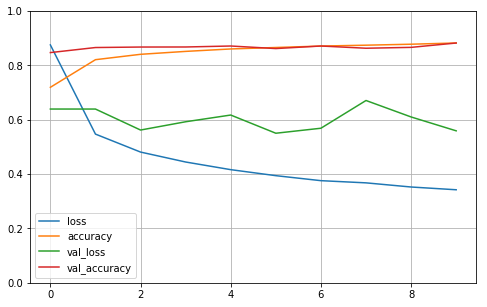

In [6]:
# 将history中的值可视化出来
def plot_learning_curves(history):
    #直接转换为DataFrame
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    # 显示网格
    plt.grid(True)
    # 设置坐标轴范围
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)

批归一化可以缓解梯度消失

In [7]:
model.evaluate(x_test_scaled, y_test)

10000/10000 [==============================] - 1s 60us/sample - loss: 0.6486 - accuracy: 0.8695


[0.6486321398705244, 0.8695]

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1